### Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import itertools

# --- 1. Define Model ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(256 * 4 * 4, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# --- 2. Sparse Training Logic ---
def apply_weight_sparsity(model, sparsity_level=0.90):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name and param.dim() > 1:
                flat_param = param.abs().flatten()
                k = int((1 - sparsity_level) * flat_param.numel())
                if k < 1: continue
                threshold = torch.topk(flat_param, k).values[-1]
                mask = (param.abs() >= threshold).float()
                param.data.mul_(mask)

# --- 3. Circuit Discovery Helpers ---
def binary_gate(x):
    return (x > 0).float() - torch.sigmoid(x).detach() + torch.sigmoid(x)

def get_gate_hook(gate_param):
    def hook(module, input, output):
        return output * binary_gate(gate_param)
    return hook

def get_hard_mask_hook(indices, device):
    def hook(module, input, output):
        mask = torch.zeros(1, output.shape[1], 1, 1).to(device)
        mask[:, indices, :, :] = 1.0
        return output * mask
    return hook

### Sparse Training

Using device: cuda

PHASE 1: Sparse Training
Epoch 1 | Loss: 1.8710
Epoch 2 | Loss: 1.4552
Epoch 3 | Loss: 1.3295
Epoch 4 | Loss: 1.2583
Epoch 5 | Loss: 1.2071
Epoch 6 | Loss: 1.1646
Epoch 7 | Loss: 1.1295
Epoch 8 | Loss: 1.0960
Epoch 9 | Loss: 1.0757
Epoch 10 | Loss: 1.0471
Epoch 11 | Loss: 1.0286
Epoch 12 | Loss: 1.0049
Epoch 13 | Loss: 0.9872
Epoch 14 | Loss: 0.9721
Epoch 15 | Loss: 0.9569
Epoch 16 | Loss: 0.9453
Epoch 17 | Loss: 0.9287
Epoch 18 | Loss: 0.9183
Epoch 19 | Loss: 0.9071
Epoch 20 | Loss: 0.8955
Epoch 21 | Loss: 0.8848
Epoch 22 | Loss: 0.8715
Epoch 23 | Loss: 0.8632
Epoch 24 | Loss: 0.8533
Epoch 25 | Loss: 0.8481

PHASE 2: Circuit Discovery

Finding circuit for: AIRPLANE
  conv1: 7 active
  conv2: 4 active
  conv3: 4 active
  > Accuracy: 100.00%


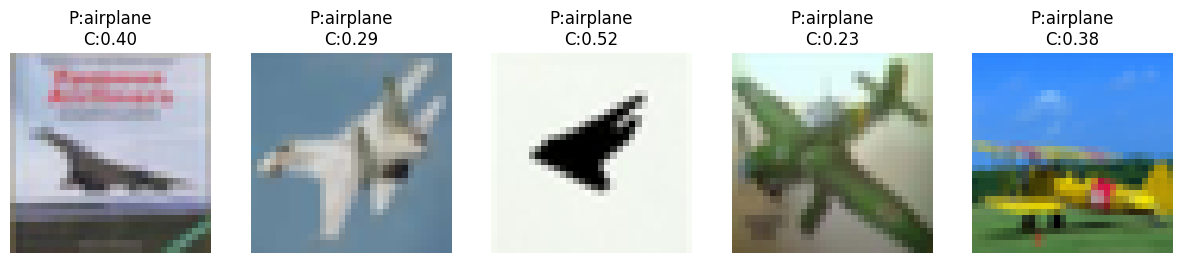


Finding circuit for: AUTOMOBILE
  conv1: 4 active
  conv2: 4 active
  conv3: 6 active
  > Accuracy: 100.00%


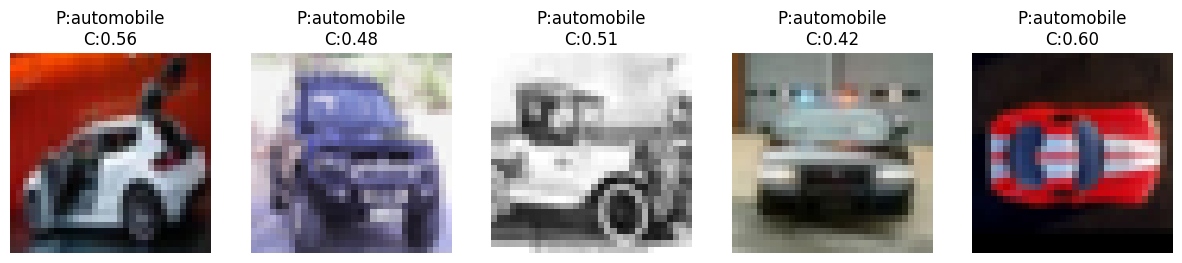


Finding circuit for: BIRD
  conv1: 4 active
  conv2: 4 active
  conv3: 4 active
  > Accuracy: 100.00%


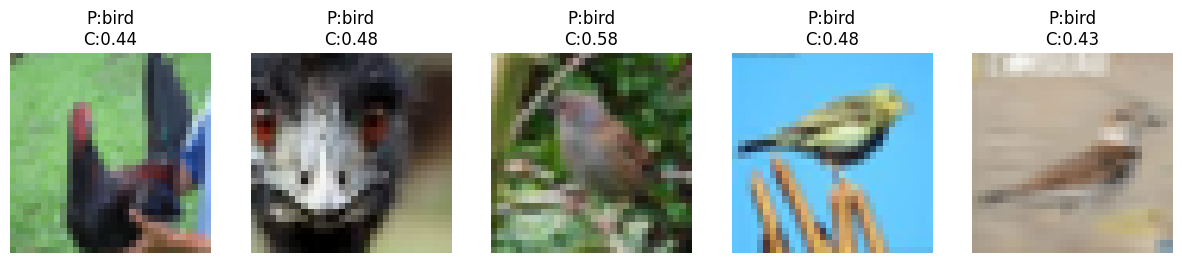

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
class_names = trainset.classes

print("\nPHASE 1: Sparse Training")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

TARGET_SPARSITY = 0.95
EPOCHS = 25

for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        apply_weight_sparsity(model, sparsity_level=TARGET_SPARSITY)
        running_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {running_loss/len(trainloader):.4f}")

for param in model.parameters():
    param.requires_grad = False

print("\nPHASE 2: Circuit Discovery")

classes_to_analyze = [0, 1, 2] 
circuit_storage = {}

for target_class_idx in classes_to_analyze:
    target_name = class_names[target_class_idx]
    print(f"\nFinding circuit for: {target_name.upper()}")

    gate_params = {}
    hooks = []
    layers_to_prune = []
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            layers_to_prune.append(name)
            gate_params[name] = nn.Parameter(torch.ones(1, module.out_channels, 1, 1).to(device) * 2.0)
            hooks.append(module.register_forward_hook(get_gate_hook(gate_params[name])))

    gate_optimizer = optim.Adam(gate_params.values(), lr=0.1)
    data_iter = iter(trainloader)

    for step in range(200):
        try:
            inputs, labels = next(data_iter)
        except StopIteration:
            data_iter = iter(trainloader)
            inputs, labels = next(data_iter)
        
        inputs, labels = inputs.to(device), labels.to(device)
        target_mask = (labels == target_class_idx)
        if target_mask.sum() == 0: continue
        
        inputs = inputs[target_mask]
        labels = labels[target_mask]
        
        gate_optimizer.zero_grad()
        outputs = model(inputs)
        task_loss = criterion(outputs, labels)
        
        l0_loss = 0
        for name in gate_params:
            l0_loss += torch.sigmoid(gate_params[name]).sum()
        
        total_loss = task_loss + (0.1 * l0_loss) 
        total_loss.backward()
        gate_optimizer.step()

    for h in hooks: h.remove()

    final_active_indices = {}
    for name in layers_to_prune:
        mask = (gate_params[name] > 0).float().detach().cpu().numpy().flatten()
        indices = np.where(mask == 1)[0]
        final_active_indices[name] = set(indices.tolist())
        print(f"  {name}: {len(indices)} active")

    circuit_storage[target_name] = final_active_indices

    inference_hooks = []
    for name in final_active_indices:
        indices_list = list(final_active_indices[name])
        inference_hooks.append(model.get_submodule(name).register_forward_hook(
            get_hard_mask_hook(torch.tensor(indices_list, device=device), device)
        ))

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            mask = labels == target_class_idx
            if mask.sum() == 0: continue
            out = model(images[mask])
            _, pred = torch.max(out, 1)
            correct += (pred == labels[mask]).sum().item()
            total += mask.sum().item()
    
    print(f"  > Accuracy: {100*correct/total:.2f}%")
    
    # Visualize 5 examples
    target_indices = [i for i, x in enumerate(testset.targets) if x == target_class_idx][:5]
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for idx, ax in zip(target_indices, axes):
        img, lbl = testset[idx]
        out = model(img.unsqueeze(0).to(device))
        prob = F.softmax(out, dim=1)
        conf, pred = torch.max(prob, 1)
        ax.imshow(img.permute(1, 2, 0) * 0.5 + 0.5)
        ax.set_title(f"P:{class_names[pred.item()]}\nC:{conf.item():.2f}")
        ax.axis('off')
    plt.show()

    for h in inference_hooks: h.remove()

In [3]:
import torch
import os
os.makedirs("weights", exist_ok=True)
torch.save(model.state_dict(), "weights/sparse_cnn.pth")
for cls_name, gates in circuit_storage.items():
    torch.save(gates, f"weights/gates_{cls_name}.pth")
print("Weights and gates saved successfully!")

Weights and gates saved successfully!


In [3]:
import torch
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

# Recreate your model
model = SimpleCNN().to(device)
model.load_state_dict(torch.load("weights/sparse_cnn.pth", map_location=device))
model.eval()

# Reload the circuit gates
circuit_storage = {}
for cls_name in ["automobile", "bird", "airplane"]:
    gate_path = f"weights/gates_{cls_name}.pth"
    if os.path.exists(gate_path):
        circuit_storage[cls_name] = torch.load(gate_path, map_location=device)
    else:
        print(f"Gate file not found for class {cls_name}")
        
print("Model and gates reloaded successfully!")


Model and gates reloaded successfully!


### IoU

In [4]:
print("\nPHASE 3: IoU Analysis")

analyzed_names = list(circuit_storage.keys())
layers = list(circuit_storage[analyzed_names[0]].keys())

for layer in layers:
    print(f"\nLayer: {layer}")
    for c1, c2 in itertools.combinations(analyzed_names, 2):
        set1 = circuit_storage[c1][layer]
        set2 = circuit_storage[c2][layer]
        
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        iou = intersection / union if union > 0 else 0
        
        print(f"  IoU ({c1} vs {c2}): {iou:.4f} (Int: {intersection}, Union: {union})")


PHASE 3: IoU Analysis

Layer: conv1
  IoU (automobile vs bird): 0.3333 (Int: 2, Union: 6)
  IoU (automobile vs airplane): 0.5714 (Int: 4, Union: 7)
  IoU (bird vs airplane): 0.3750 (Int: 3, Union: 8)

Layer: conv2
  IoU (automobile vs bird): 0.1429 (Int: 1, Union: 7)
  IoU (automobile vs airplane): 0.3333 (Int: 2, Union: 6)
  IoU (bird vs airplane): 0.0000 (Int: 0, Union: 8)

Layer: conv3
  IoU (automobile vs bird): 0.0000 (Int: 0, Union: 10)
  IoU (automobile vs airplane): 0.0000 (Int: 0, Union: 10)
  IoU (bird vs airplane): 0.0000 (Int: 0, Union: 8)



PHASE 4: Visualizing Shared Features
Visualizing Shared Channel: 11 in conv2 (Shared by Airplane & Bird)


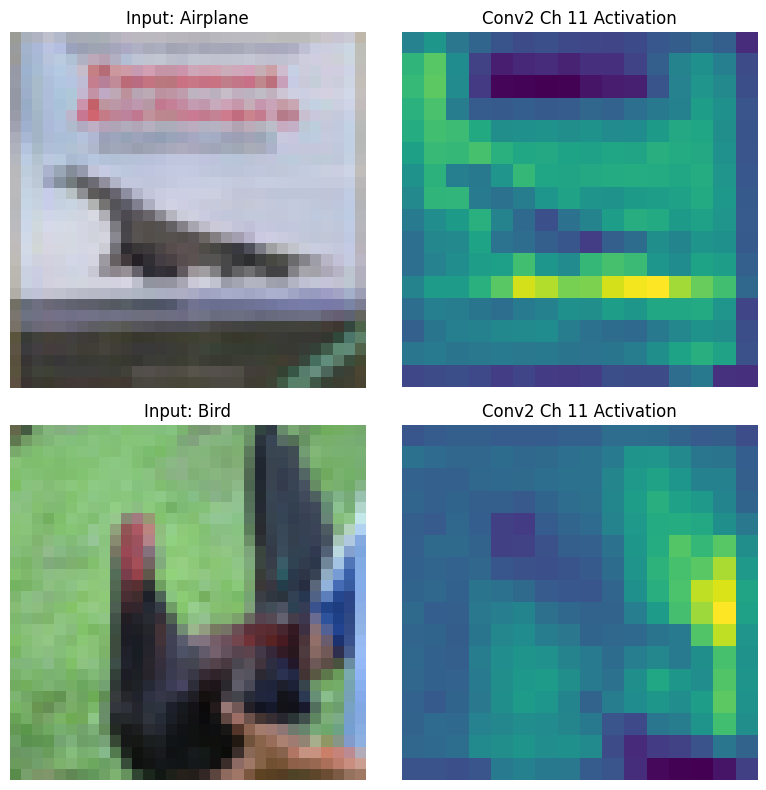

In [5]:
# --- PHASE 4: Shared Feature Visualization ---
print("\nPHASE 4: Visualizing Shared Features")

# 1. Find the shared channel in conv2 between Airplane (idx 0) and Bird (idx 2)
plane_circuit = circuit_storage['airplane']['conv1']
bird_circuit = circuit_storage['bird']['conv1']
shared_channels = list(plane_circuit.intersection(bird_circuit))

if not shared_channels:
    print("No shared channels found in conv2 for visualization.")
else:
    target_channel_idx = shared_channels[0] # Pick the first shared one
    print(f"Visualizing Shared Channel: {target_channel_idx} in conv2 (Shared by Airplane & Bird)")

    # 2. Get one Airplane image and one Bird image
    plane_idx = [i for i, x in enumerate(testset.targets) if x == 0][0]
    bird_idx = [i for i, x in enumerate(testset.targets) if x == 2][0]
    
    img_plane, _ = testset[plane_idx]
    img_bird, _ = testset[bird_idx]
    
    # 3. Define Hook to capture activation
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # Attach hook to conv2
    handle = model.conv2.register_forward_hook(get_activation('conv2'))

    # 4. Pass images through model
    # Airplane Pass
    model(img_plane.unsqueeze(0).to(device))
    act_plane = activation['conv2'][0, target_channel_idx].cpu()

    # Bird Pass
    model(img_bird.unsqueeze(0).to(device))
    act_bird = activation['conv2'][0, target_channel_idx].cpu()

    handle.remove() # Clean up

    # 5. Plotting
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    
    # Airplane Row
    axes[0, 0].imshow(img_plane.permute(1, 2, 0) * 0.5 + 0.5)
    axes[0, 0].set_title("Input: Airplane")
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(act_plane, cmap='viridis')
    axes[0, 1].set_title(f"Conv2 Ch {target_channel_idx} Activation")
    axes[0, 1].axis('off')

    # Bird Row
    axes[1, 0].imshow(img_bird.permute(1, 2, 0) * 0.5 + 0.5)
    axes[1, 0].set_title("Input: Bird")
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(act_bird, cmap='viridis')
    axes[1, 1].set_title(f"Conv2 Ch {target_channel_idx} Activation")
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()